In [1]:
import tensorflow as tf
import numpy as np 
import numpy as np
import scipy.sparse as sp 
import matplotlib.pyplot as plt
import numpy as np
import scipy.io 
from tensorflow.python.framework import ops
from sklearn.metrics.pairwise import pairwise_distances 
from sklearn.neighbors import kneighbors_graph
from matplotlib.colors import ListedColormap 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report 
from sklearn.neighbors import KDTree
from scipy.sparse import csr_matrix 
from scipy.sparse import csr_matrix
tf.compat.v1.disable_eager_execution()


In [2]:
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)
 


In [3]:

def adjacency_matrix(ALL_X, k=10):     
    N = ALL_X.shape[0]
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            A[i, j] = cosine_similarity(ALL_X[i], ALL_X[j])
    # Convert the graph to a sparse matrix and return it
    ALL_L = csr_matrix(A)
    return ALL_L

In [4]:
def create_placeholders(n_x, n_y):

    x_in = tf.compat.v1.placeholder(tf.float32,  [None, n_x], name = "x_in")
    y_in = tf.compat.v1.placeholder(tf.float32, [None, n_y], name = "y_in")
    lap = tf.compat.v1.placeholder(tf.float32, [None, None], name = "lap")
    mask_train = tf.compat.v1.placeholder(tf.float32, name = "mask_train")
    mask_test = tf.compat.v1.placeholder(tf.float32, name = "mask_test")
    isTraining = tf.compat.v1.placeholder_with_default(True, shape=())
    
    return x_in, y_in, lap, mask_train, mask_test, isTraining
 

In [5]:
def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

In [6]:
def initialize_parameters():
   
    tf.compat.v1.set_random_seed(1)

    x_w1 = tf.compat.v1.get_variable("x_w1", [224,118], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b1 = tf.compat.v1.get_variable("x_b1", [118], initializer = tf.compat.v1.zeros_initializer())
     
    x_w2 = tf.compat.v1.get_variable("x_w2", [118,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    x_b2 = tf.compat.v1.get_variable("x_b2", [12], initializer = tf.compat.v1.zeros_initializer())
    
    
    parameters = {"x_w1": x_w1,
                  "x_b1": x_b1,
                  "x_w2": x_w2,
                  "x_b2": x_b2}
                  
    return parameters
 

In [7]:

def GCN_layer(x_in, L_, weights): 
    x_mid = tf.matmul(x_in, weights)
    x_out = tf.matmul(L_, x_mid)
    
    return x_out

In [8]:
def mynetwork(x, parameters, Lap, isTraining, momentums = 0.9):

    with tf.compat.v1.name_scope("x_layer_1"):
        
         x_z1_bn = tf.compat.v1.layers.batch_normalization(x, momentum = momentums, training = isTraining)          
         x_z1 = GCN_layer(x_z1_bn, Lap, parameters['x_w1']) + parameters['x_b1']
         x_z1_bn = tf.compat.v1.layers.batch_normalization(x_z1, momentum = momentums, training = isTraining)   
         x_a1 = tf.nn.relu(x_z1_bn)     

    with tf.compat.v1.name_scope("x_layer_2"):
         
         x_z2_bn = tf.compat.v1.layers.batch_normalization(x_a1, momentum = momentums, training = isTraining)            
         x_z2 = GCN_layer(x_z2_bn, Lap, parameters['x_w2']) + parameters['x_b2']         
         
    l2_loss =  tf.nn.l2_loss(parameters['x_w1']) + tf.nn.l2_loss(parameters['x_w2'])
                
    return x_z2, l2_loss
 

In [9]:

def mynetwork_optimaization(y_est, y_re, l2_loss, mask, reg, learning_rate, global_step):
    
    with tf.compat.v1.name_scope("cost"):
         cost = (tf.nn.softmax_cross_entropy_with_logits(logits = y_est, labels = tf.stop_gradient( y_re))) +  reg * l2_loss
         mask = tf.cast(mask, dtype = tf.float32)
         mask /= tf.reduce_mean(mask)
         cost *= mask
         cost = tf.reduce_mean(cost) +  reg * l2_loss
         
    with tf.compat.v1.name_scope("optimization"):
         update_ops = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
         optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost,  global_step=global_step)
         optimizer = tf.group([optimizer, update_ops])
         
    return cost, optimizer 
 

In [10]:
def masked_accuracy(preds, labels, mask):

      correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
      accuracy = tf.cast(correct_prediction, "float")
      mask = tf.cast(mask, dtype = tf.float32)
      mask /= tf.reduce_mean(mask)
      accuracy *= mask
      
      return tf.reduce_mean(accuracy)
 

In [11]:
def train_mynetwork(x_all, y_all, L_all, Cuprite_norm, mask_in, mask_out, learning_rate = 0.001, beta_reg = 0.001, num_epochs = 200, print_cost = True):
                                    #GCN_mask_TR, GCN_mask_TE
    ops.reset_default_graph()                                                         
    (m, n_x) = x_all.shape             # n_x=200
    (m, n_y) = y_all.shape     
    print(L_all.shape)    # n_y=16  
    # adj_matrix=adj_matrix.todense()
    # L_all = np.array(L_all.todense(), dtype=int)
    # adj_matrix = np.array(adj_matrix.todense(), dtype=int)
    costs = []                                        
    costs_dev = []
    train_acc = []
    val_acc = []
    
    x_in, y_in, lap, mask_train, mask_test, isTraining = create_placeholders(n_x, n_y) 
    
    parameters = initialize_parameters()
    with tf.compat.v1.name_scope("network"):
        x_out, l2_loss = mynetwork(x_in, parameters, lap, isTraining)
    global_step = tf.Variable(0, trainable=False)
    
    with tf.compat.v1.name_scope("optimization"):
         cost, optimizer = mynetwork_optimaization(x_out, y_in, l2_loss, mask_train, beta_reg, learning_rate, global_step)

    with tf.compat.v1.name_scope("metrics"):
         accuracy_train = masked_accuracy(x_out, y_in, mask_train)
         accuracy_test= masked_accuracy(x_out, y_in, mask_test)
         
    init = tf.compat.v1.global_variables_initializer()
   
    with tf.compat.v1.Session() as sess:
        # Configure session to use GPU
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.compat.v1.Session(config=config)
        
        sess.run(init)
        # Do the training loop
        for epoch in range(num_epochs + 1):

            _, epoch_cost, epoch_acc = sess.run([optimizer, cost, accuracy_train], feed_dict={x_in: x_all, y_in: y_all, lap: L_all, mask_train: mask_in, mask_test: mask_out, isTraining: True})
            
            
            features, overall_cost_dev, overall_acc_dev = sess.run([x_out, cost, accuracy_test], feed_dict={x_in: x_all, y_in: y_all, lap: L_all, mask_train: mask_in, mask_test: mask_out, isTraining: False})
            # print ("epoch %i: Train_loss: %f, Val_loss: %f, Train_acc: %f, Val_acc: %f" % (epoch, epoch_cost, overall_cost_dev, epoch_acc, overall_acc_dev))
            
        
            costs.append(epoch_cost)
            train_acc.append(epoch_acc)
            costs_dev.append(overall_cost_dev)
            val_acc.append(overall_acc_dev)
            
        print("Training")
        for i in range(5):
            print(f"epoch {i*50}: Train_loss: {costs[i*50]}, Train_acc: {train_acc[i*50]}") 
            
        print("Validating")
        for j in range(5):
            print(f"epoch {j*50}: Validating_loss: {costs_dev[j*50]}, Validating_acc: {val_acc[j*50]}")

        # Cuprite_out=sess.run([x_out], feed_dict={x_in:Cuprite_norm, lap:adj_matrix, isTraining: False})  
        # Cuprite_out = Cuprite_out[0] 
        # num_labels = 12
        # labels = np.argmax(Cuprite_out, axis=1)
        # labels = labels.reshape(-1, 1) 
 
        # # Reshape label array to 2D array
        # label_2d = np.reshape(labels, (512, 614))

        # # Define color map for elements
        # colors = ['#8B0000', '#FFA500', '#FFFF00', '#00CED1', '#228B22', '#008000', '#808080', '#FFC0CB', '#800080', '#FF69B4', '#0000FF', '#a52a2a']
        # # colors = ['#660000', '#CC6600', '#CCCC00', '#006666', '#004400', '#003300', '#555555', '#FF99CC', '#660066', '#FF3399', '#000066', '#660000']
        # cmap = ListedColormap(colors)

        # # Define color for unlabeled pixels
        # cmap.set_under('white')

        # # Plot the image with labels
        # fig, ax = plt.subplots()
        # im = ax.imshow(label_2d, cmap=cmap, vmin=0.5, vmax=12.5, interpolation='nearest')
        # cbar = fig.colorbar(im, ax=ax, ticks=range(1, 13))
        # cbar.ax.set_yticklabels(["#1 Alunite", "#2 Andradite", "#3 Buddingtonite", "#4 Dumortierite", "#5 Kaolinite1", 
        #                          "#6 Kaolinite2", "#7 Muscovite", "#8 Montmorillonite", "#9 Nontronite", "#10 Pyrope",
        #                          "#11 Sphene", "#12 Chalcedony"])
        # cbar.ax.tick_params(labelsize=8)
        # cbar.ax.set_ylabel('Mineral Labels', fontsize=10)
        # plt.show()


        # plot the cost      
        plt.plot(np.squeeze(costs), label='Training cost')
        plt.plot(np.squeeze(costs_dev), label='Validation cost')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        # plot the accuracy 
        plt.plot(np.squeeze(train_acc), label='Training accuracy')
        plt.plot(np.squeeze(val_acc), label='Validation accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
    
        return parameters , val_acc, features

(1051, 1051)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Training
epoch 0: Train_loss: 3.734541654586792, Train_acc: 0.050271738320589066
epoch 50: Train_loss: 1.0405678749084473, Train_acc: 0.7350547909736633
epoch 100: Train_loss: 0.8278754949569702, Train_acc: 0.7934788465499878
epoch 150: Train_loss: 0.7303870320320129, Train_acc: 0.8478268980979919
epoch 200: Train_loss: 0.6755666136741638, Train_acc: 0.8491855263710022
Validating
epoch 0: Validating_loss: 2.653686285018921, Validating_acc: 0.15238097310066223
epoch 50: Validating_loss: 1.3135952949523926, Validating_acc: 0.44444456696510315
epoch 100: Validating_loss: 0.8398948907852173, Validating_acc: 

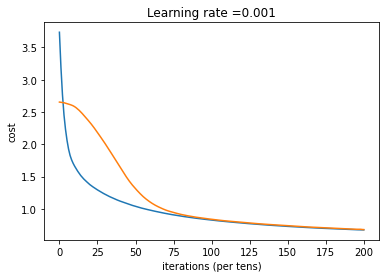

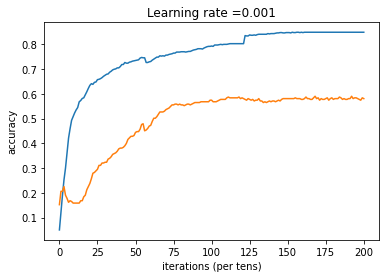

Parameters have been trained!
(315,) (315,)
Confusion Matrix:
 [[ 2  0  0  3  0  1  1  1  0  4  0  0]
 [ 0 21  0  0  0  0  0  3  0 14  0  0]
 [ 0  2  1  0  0  0  1  0  0  1  0  0]
 [ 0  0  0 13  0  5  0  4  3  4  0  0]
 [ 0  1  0  0 41  0  0  0  1 11  0  0]
 [ 1  0  0  0  0  9  0  2  5  3  0  0]
 [ 0  2  4  0  0  0 21  2  0  6  0  0]
 [ 0  1  0  0  0  1  1 23  0  6  0  0]
 [ 0  1  0  0  0  2  0  3 39 20  0  0]
 [ 0  0  0  0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  2  0]
 [ 0  0  1  0  0  1  2  2  0  4  0  5]]
Accuracy: 0.580952380952381
Precision: 0.6782319938021693
Recall: 0.527409725022966
F1-score: 0.5257999404857899
ROC AUC score: 0.8613650851108989


In [12]:
Cuprite_data = scipy.io.loadmat('Cuprite.mat')
Cuprite_data = Cuprite_data['X']
CmaxVal = np.amax(Cuprite_data)
CminVal = np.amin(Cuprite_data)
Cuprite_shifted = Cuprite_data + abs(CminVal)
Cuprite_norm = Cuprite_shifted / (abs(CminVal) + abs(CmaxVal))
Cuprite_norm = Cuprite_norm + 1e-6
Cuprite_norm = Cuprite_norm.reshape(-1, Cuprite_norm.shape[-1])

# Cuprite_graph = scipy.io.loadmat('adj_sparse.mat')
# adj_matrix = Cuprite_graph['adj_sparse']
# print(adj_matrix.shape)

Labeled_points = scipy.io.loadmat('Labeled_Cuprite_Data/data_points.mat')['data_points']
maxVal = np.amax(Labeled_points)
minVal = np.amin(Labeled_points)
Labeled_points_shifted = Labeled_points + abs(minVal)
Labeled_points_norm = Labeled_points_shifted / (abs(minVal) + abs(maxVal))
Labeled_points_norm = Labeled_points_norm + 1e-6

Labels = scipy.io.loadmat('Labeled_Cuprite_Data/labels.mat')['labels']
Labels = Labels.T
num_classes = 12
Labels_onehot = tf.keras.utils.to_categorical(Labels, num_classes)

GCN_mask_TR = sample_mask(np.arange(0, 736), Labels.shape[0])
GCN_mask_TE = sample_mask(np.arange(736, 1051), Labels.shape[0])

temp = adjacency_matrix(Labeled_points)
 
temp = temp.astype(int)
temp=temp.todense() 



# sparse_adj_matrix = csr_matrix(adj_matrix)
# sparse_adj_matrix = sparse_adj_matrix.astype(int)

# # sparse_adj_matrix=sparse_adj_matrix.todense()


parameters, val_acc, features = train_mynetwork(Labeled_points_norm, Labels_onehot, temp , Cuprite_norm, GCN_mask_TR, GCN_mask_TE)

features = features[736:1051]
Labels_onehot = Labels_onehot[736:1051]

y_pred = np.argmax(features, axis=1)
y_true = np.argmax(Labels_onehot, axis=1)


print(y_pred.shape, y_true.shape)
cm = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:\n", cm)

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='macro'))
print("Recall:", recall_score(y_true, y_pred, average='macro'))
print("F1-score:", f1_score(y_true, y_pred, average='macro'))
print("ROC AUC score:", roc_auc_score(Labels_onehot, features, multi_class='ovr'))
